## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# pythonpath=r'/content/drive/MyDrive/pgdm_aiml_projects/Automatic Ticket Classification Assignment/'

## Importing the necessary libraries

In [3]:
import json 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Libraries for text preprocessing and analysis
import re,nltk,spacy,string
nlp=spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

In [5]:
# Libraries for model evaluation metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [6]:
#Remove warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
# Opening JSON file 
# f = open(pythonpath+'complaints.json')
f = open('complaints.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'complaints_what_happened', '_source.product':'tag'}, inplace=True)

In [11]:
#Assign nan in place of blanks in the complaints column
df['complaints_what_happened'].replace("", np.nan, inplace=True)

In [12]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaints_what_happened'], inplace=True)

df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()
    
    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)
    
    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)
    
    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [14]:
#Write your function to Lemmatize the texts
def lemma_texts(text):     
        
    # Initialize empty list to store lemmas
    lemma_list = []
    
    # Extract lemmas of given text and add to the list 'sent'
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)

In [15]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaints_what_happened'].apply(clean_texts)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,complaints_what_happened,_source.sub_issue,_source.consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in xx/xx/ and was...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,"chase card was reported on xx/xx/. however, fr..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,"on xx/xx/, while trying to book a xxxx xxxx ..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for {$.} i deposit ...


In [16]:
# df_clean = pd.DataFrame({'complaints':df['complaints'], 'lemmatized':df['complaints'].apply(lemma_texts)})
df['lemmatized complaints'] = df['complaints_what_happened'].apply(lemma_texts)

In [17]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaints','lemmatized complaints']]

In [18]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: get_pos_tags(x['lemmatized complaints']), axis=1)


In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaints,lemmatized complaints,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx XXXX and -PRO...,morning name stop cardmember service debt veri...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,-PRON- upgrade -PRON- xxxx xxxx card in XX / X...,card agent upgrade anniversary date agent info...
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / xx/2019 . however...,report application -pron- identity consent ser...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a xxxx x...",xxxx ticket offer ticket reward card informati...
14,my grand son give me check for {$.} i deposit ...,-PRON- grand son give -PRON- check for { $ 160...,son account account money son check money mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




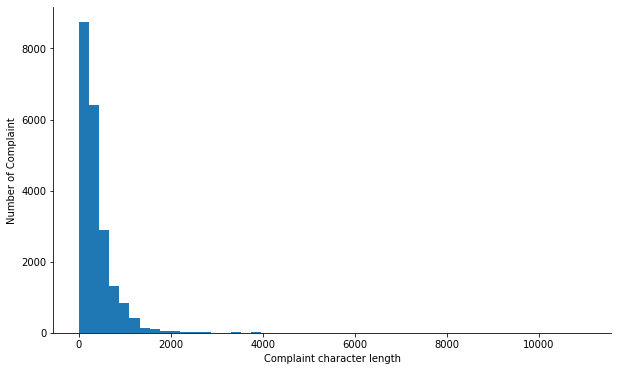

In [20]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

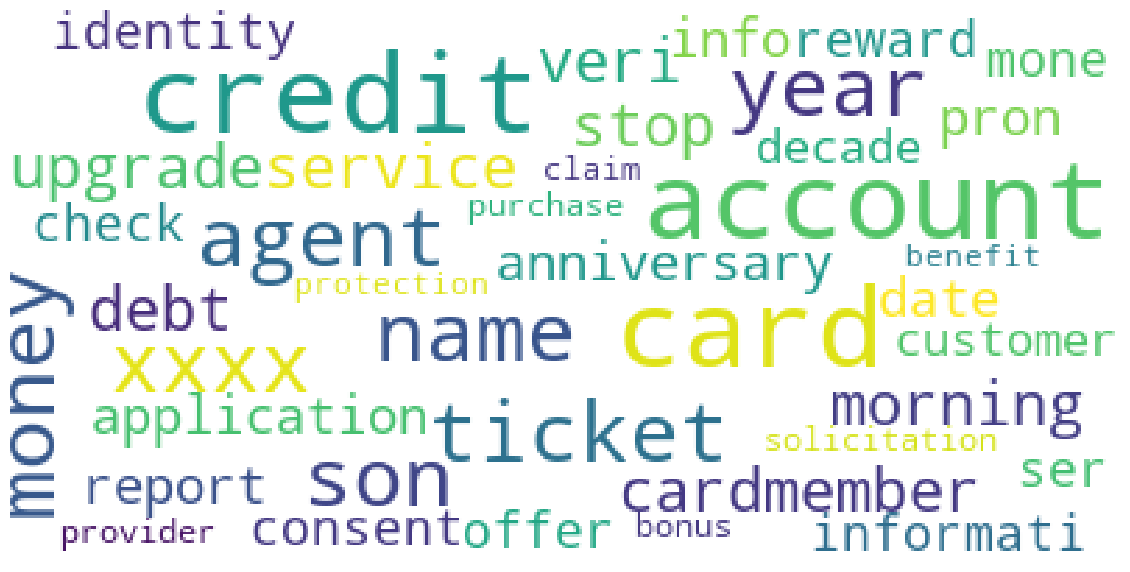

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stop_words = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_font_size=40,
                          max_words=40, 
                          random_state=100
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(20,20))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [22]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [23]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [24]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,account,45258
1,credit,30699
2,card,27279
3,pron,24367
4,xxxx,21489
5,payment,20820
6,charge,16156
7,time,16129
8,bank,16025
9,day,12862


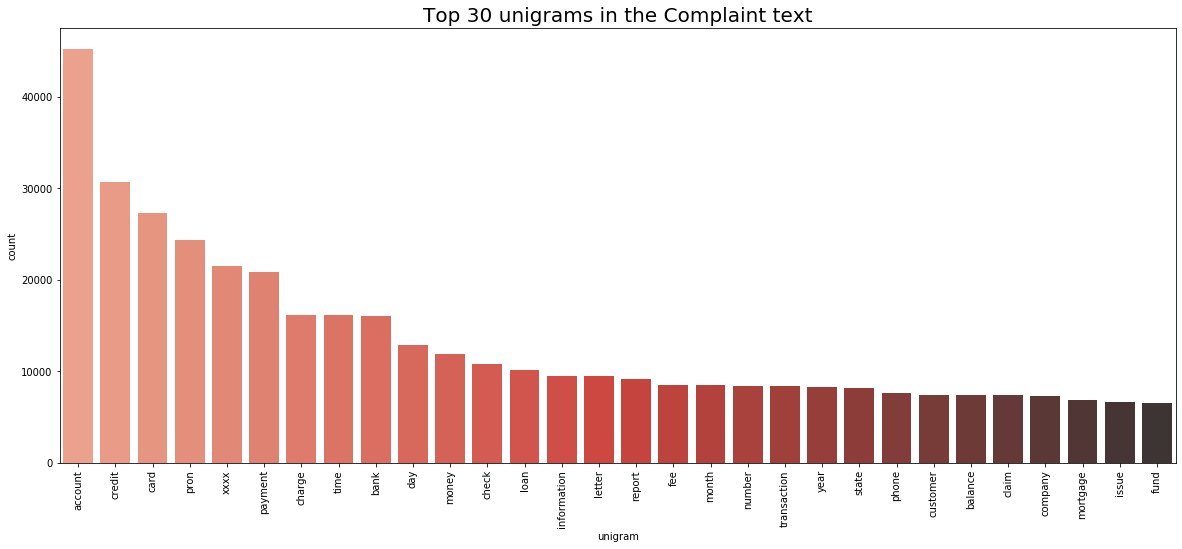

In [25]:
plt.figure(figsize=(20,8))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="Reds_d")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the Complaint text", fontsize=20)
plt.show()

In [26]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [27]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['Bigram' , 'count'])
df_bigram.head(10)

,Bigram,count
0,credit card,11278
1,pron account,4688
2,credit report,3743
3,customer service,2625
4,account account,2491
5,xxxx xxxx,2404
6,checking account,2030
7,bank account,1987
8,debit card,1817
9,credit score,1663


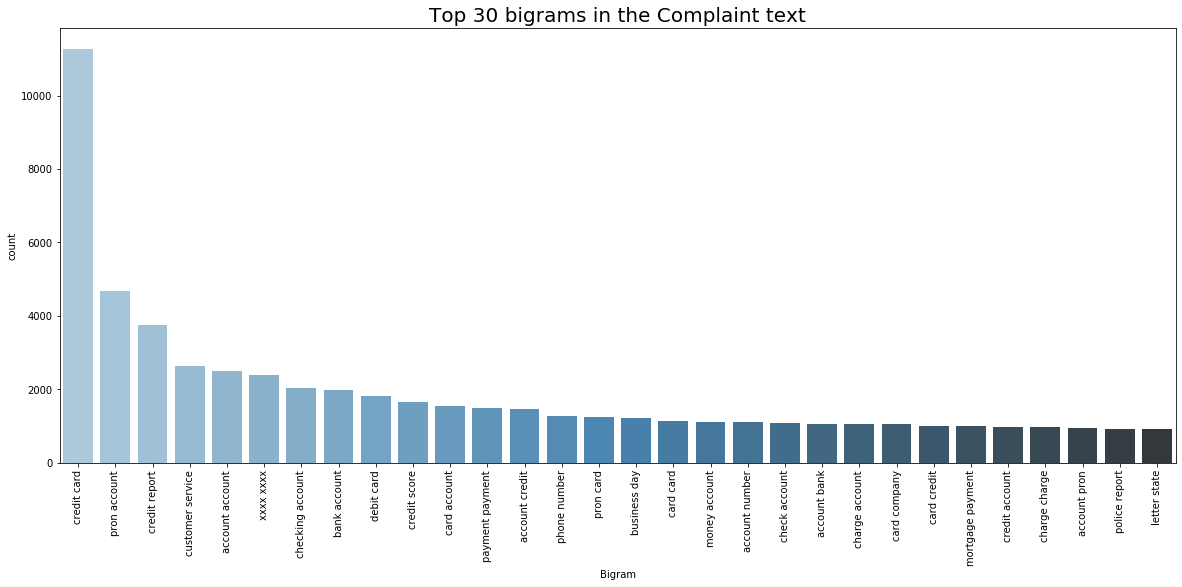

In [28]:
plt.figure(figsize=(20,8))
sns.barplot(x='Bigram', y='count', data=df_bigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text", fontsize=20)
plt.show()

In [29]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [30]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,credit card account,998
1,credit card company,897
2,charge credit card,572
3,credit card credit,525
4,xxxx xxxx xxxx,492
5,inquiry credit report,476
6,account credit card,444
7,card credit card,430
8,credit card charge,348
9,credit reporting agency,336


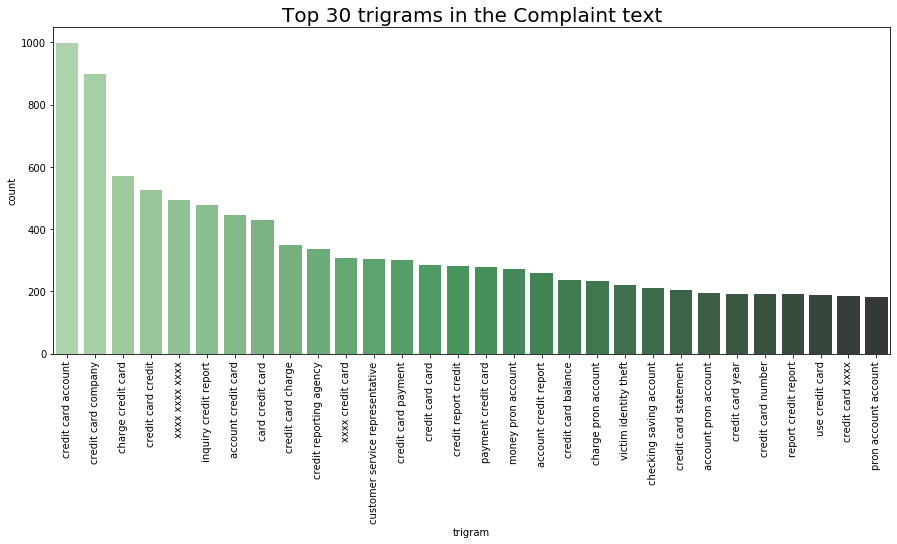

In [31]:
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Greens_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [32]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [33]:
#All masked texts has been removed
df_clean.head()

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx XXXX and -PRO...,morning name stop cardmember service debt veri...,morning name stop cardmember service debt veri...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,-PRON- upgrade -PRON- xxxx xxxx card in XX / X...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / xx/2019 . however...,report application -pron- identity consent ser...,report application -pron- identity consent ser...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a xxxx x...",xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
14,my grand son give me check for {$.} i deposit ...,-PRON- grand son give -PRON- check for { $ 160...,son account account money son check money mone...,son account account money son check money mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [34]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [35]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [36]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [38]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

6147

In [39]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,pron,deposit,day,branch,checking,number,transaction,xxxx,business,transfer
Topic 2,credit,card,report,inquiry,account,score,company,information,limit,application,debt,letter,year,pron,balance
Topic 3,payment,balance,month,fee,statement,pay,time,day,mortgage,date,auto,credit,xxxx,year,account
Topic 4,charge,card,fee,dispute,transaction,merchant,purchase,xxxx,claim,fraud,service,refund,statement,balance,time
Topic 5,loan,mortgage,modification,home,xxxx,property,letter,year,document,time,rate,pron,request,foreclosure,information


In [40]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)
topic_results.argmax(axis=1)

array([4, 1, 1, ..., 3, 2, 2], dtype=int64)

In [41]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [42]:
#Print the first 5 Complaint for each of the Topics
First5_comps=df_clean.groupby('Topic').head(5)
First5_comps.sort_values('Topic')

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
14,my grand son give me check for {$.} i deposit ...,-PRON- grand son give -PRON- check for { $ 160...,son account account money son check money mone...,son account account money son check money mone...,0
17,with out notice j.p. morgan chase restricted m...,with out notice J.P. Morgan Chase restrict -PR...,notice account debit card branch advise custom...,notice account debit card branch advise custom...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by Chase auto and xx...,account auto xxxx,account auto,0
27,i opened an account with chase bank on xxxx an...,-PRON- open an account with chase bank on XXXX...,account code bonus term everything account xxx...,account code bonus term everything account de...,0
35,i opened the saving account for the {$.} bonus...,-PRON- open the saving account for the { $ 25....,saving account bonus bonus auto transfer check...,saving account bonus bonus auto transfer check...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,-PRON- upgrade -PRON- xxxx xxxx card in XX / X...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,1
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / xx/2019 . however...,report application -pron- identity consent ser...,report application -pron- identity consent ser...,1
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a xxxx x...",xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,1
15,can you please remove inquiry,Can -PRON- please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,-PRON- have a Chase credit card which be incor...,credit card datum credit report company help i...,credit card datum credit report company help i...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [43]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [44]:
df_clean.head()

,complaints,lemmatized complaints,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx XXXX and -PRO...,morning name stop cardmember service debt veri...,morning name stop cardmember service debt veri...,Theft/Dispute Reporting
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,-PRON- upgrade -PRON- xxxx xxxx card in XX / X...,card agent upgrade anniversary date agent info...,card agent upgrade anniversary date agent info...,Others
10,"chase card was reported on xx/xx/. however, fr...",Chase Card be report on XX / xx/2019 . however...,report application -pron- identity consent ser...,report application -pron- identity consent ser...,Others
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on XX / XX/2018 , while try to book a xxxx x...",xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Others
14,my grand son give me check for {$.} i deposit ...,-PRON- grand son give -PRON- check for { $ 160...,son account account money son check money mone...,son account account money son check money mone...,Bank Account Services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [45]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Bank Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean.shape

(21072, 5)

In [47]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaints','Topic']]

In [48]:
training_data.head()

,complaints,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,1
10,"chase card was reported on xx/xx/. however, fr...",1
11,"on xx/xx/, while trying to book a xxxx xxxx ...",1
14,my grand son give me check for {$.} i deposit ...,0


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [50]:
# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report,accuracy_score

In [52]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

### 1) Logistic Regression

In [53]:
lr = LogisticRegression().fit(X_train, y_train)
predicted_lr = lr.predict(X_test)

print("Classification Report:-")
print(classification_report(y_test, predicted_lr))

accuracy_lr=round(accuracy_score(y_test, predicted_lr),4)*100
print("Accuracy of Logistic Regression:-",accuracy_lr,"%")

Classification Report:-
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1053
           1       0.90      0.90      0.90      1015
           2       0.93      0.85      0.89       457
           3       0.88      0.89      0.89       916
           4       0.92      0.91      0.91       774

    accuracy                           0.90      4215
   macro avg       0.90      0.89      0.90      4215
weighted avg       0.90      0.90      0.90      4215

Accuracy of Logistic Regression:- 89.92 %


### 2) Decision Trees

In [54]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

predicted_dt = dt.predict(X_test)

print("Classification Report:-")
print(classification_report(y_test, predicted_dt))

accuracy_dt=round(accuracy_score(y_test, predicted_dt),4)*100
print("Accuracy of Decision Trees-",accuracy_dt,"%")

Classification Report:-
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      1053
           1       0.79      0.78      0.78      1015
           2       0.70      0.73      0.72       457
           3       0.72      0.73      0.73       916
           4       0.77      0.74      0.76       774

    accuracy                           0.76      4215
   macro avg       0.75      0.75      0.75      4215
weighted avg       0.76      0.76      0.76      4215

Accuracy of Decision Trees- 75.87 %


### 3) Random Forest

In [55]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

predicted_rf = rfc.predict(X_test)

print("Classification Report:-")
print(classification_report(y_test, predicted_rf))

accuracy_rf=round(accuracy_score(y_test, predicted_rf),4)*100
print("Accuracy of Random Forest-",accuracy_rf,"%")

Classification Report:-
              precision    recall  f1-score   support

           0       0.78      0.92      0.84      1053
           1       0.80      0.83      0.82      1015
           2       0.88      0.46      0.61       457
           3       0.80      0.81      0.80       916
           4       0.86      0.83      0.85       774

    accuracy                           0.81      4215
   macro avg       0.82      0.77      0.78      4215
weighted avg       0.81      0.81      0.80      4215

Accuracy of Random Forest- 80.76 %


### 4) Gaussian Naive Bayes

In [56]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted_nb = nb.predict(X_test.toarray())

print("Classification Report:-")
print(classification_report(y_test, predicted_nb))

accuracy_nb=round(accuracy_score(y_test, predicted_nb),4)*100
print("Accuracy of Gaussian Naive Bayes-",accuracy_nb,"%")

Classification Report:-
              precision    recall  f1-score   support

           0       0.41      0.25      0.31      1053
           1       0.38      0.29      0.33      1015
           2       0.14      0.46      0.22       457
           3       0.42      0.29      0.34       916
           4       0.46      0.43      0.44       774

    accuracy                           0.32      4215
   macro avg       0.36      0.34      0.33      4215
weighted avg       0.39      0.32      0.34      4215

Accuracy of Gaussian Naive Bayes- 32.31 %


### Model Summary

In [57]:
model_summary_df=pd.DataFrame({'Model':['Logistic Regression','Decision Trees','Random Forest','Gaussian Naive Bayes'],
                               'Accuracy (in %)':[accuracy_lr,accuracy_dt,accuracy_rf,accuracy_nb]})

model_summary_df

,Model,Accuracy (in %)
0,Logistic Regression,89.92
1,Decision Trees,75.87
2,Random Forest,80.76
3,Gaussian Naive Bayes,32.31


##### Thus by comapring the applied Machine Learning Algorithms, we can conclude that Logistic Regression Performs better than the other models

### Infering the best model

In [58]:
def predict_topic(text):
    Topic_names = {0:'Bank account services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [59]:
df_complaints = pd.DataFrame({'complaints': ["To whom it may concern, Chase bank charged wrongly overdraft fees, I have alert of low balance or unsuficent fee balance and always deposit immediatly to cover transactions if needed but Chase always changed the order and charged me overdraft fee anyway. when you call they said their per their guidelines they don't refund more then 2 overdrawft doesn't matter bank fault or not.Taken {$34.00} from people is money just because you can is not Ok.See attached documents. When Chase refund, they always find the way to take back what they refunded in first place.",
                                            "Chase is marketing credit cards to those of us with good credit like it's going out of style. Be careful - the marketing is not clear. IF you already have a SWA Chase personal card, do not apply for the new one online. This has sent me through a XXXX triangle, wasting my time and therefore money.It appears in the middle of XX/XX/2018, Chase expanded their undisclosed 5/24 rule to include ALL co-branded cards, not just SWA, yet the marketing machine continues to ignore this policy and the Agents on the phone are not well trained. I am contacting the credit bureau b/c two of the cards opened are not mine - that is the silver lining here. However, the issue with incessant marketing of their branded cards to customers, plus this confusing 5/24 rule and lack of Agent phone training, is false advertising. The information is still relatively opaque, as Chase never comments on the 5/24 rule, but multiple reader and community data points suggest denials due to 5/24 for cards previously exempt. CFPB staff, please help educate consumers and hold the big banks accountable for deceptive trade practices. I do not believe this is intentional on Chase 's part, but the second to last Agent did encourage me to file a complaint here, so be it.",
                                            "What is the procedure to know my CIBIL score?",
                                            "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                            "Where are the bank branches in the city of Mumbai?",
                                            "unwanted service activated and money deducted automatically"]})
df_complaints

,complaints
0,"To whom it may concern, Chase bank charged wro..."
1,Chase is marketing credit cards to those of us...
2,What is the procedure to know my CIBIL score?
3,I can not get from chase who services my mortg...
4,The bill amount of my credit card was debited ...
5,I want to open a salary account at your downto...
6,"Yesterday, I received a fraudulent email regar..."
7,Where are the bank branches in the city of Mum...
8,unwanted service activated and money deducted ...


In [60]:
df_complaints['Predicted Topic'] = df_complaints['complaints'].apply(lambda x: predict_topic([x]))
df_complaints

,complaints,Predicted Topic
0,"To whom it may concern, Chase bank charged wro...",Credit card or prepaid card
1,Chase is marketing credit cards to those of us...,Others
2,What is the procedure to know my CIBIL score?,Others
3,I can not get from chase who services my mortg...,Theft/Dispute Reporting
4,The bill amount of my credit card was debited ...,Others
5,I want to open a salary account at your downto...,Bank account services
6,"Yesterday, I received a fraudulent email regar...",Credit card or prepaid card
7,Where are the bank branches in the city of Mum...,Bank account services
8,unwanted service activated and money deducted ...,Bank account services
